In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

In [10]:
# Dataset preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion-MNIST
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
# Split train set into train and validation
train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

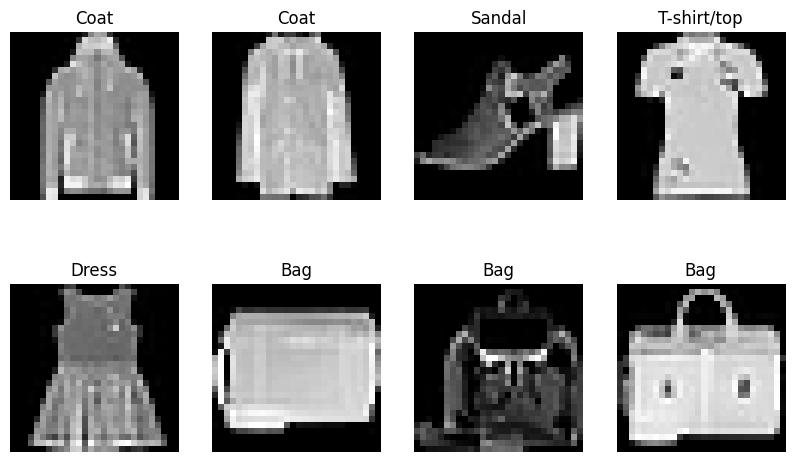

In [11]:
# **Langkah 2: Exploratory Data Analysis (EDA)**
classes = dataset.classes

# Menampilkan beberapa gambar dari dataset
data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(10, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].squeeze().numpy() * 0.5 + 0.5, cmap='gray')  # Denormalisasi
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()


In [12]:
# **Langkah 3: Membuat Arsitektur CNN**
# CNN Model
def create_cnn_model(kernel_size, pooling_type):
    class CNN(nn.Module):
        def __init__(self):
            super(CNN, self).__init__()
            self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
            self.pool = pooling_type(kernel_size=2, stride=2)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
            self.fc1 = nn.Linear(64 * 7 * 7, 512)
            self.fc2 = nn.Linear(512, 10)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 64 * 7 * 7)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    return CNN()

In [13]:
# **Langkah 4: Melakukan Training dan Evaluasi**
def train_and_evaluate(model, optimizer_name, num_epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_name == "RMSProp":
        optimizer = optim.RMSprop(model.parameters(), lr=0.01)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    early_stop_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        accuracy = 100 * correct / total

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= 10:
            print("Early stopping triggered.")
            break

    return model, best_val_loss, accuracy

In [14]:
# **Langkah 5: Eksperimen dengan Variasi Parameter**
# Configurations
kernel_sizes = [3, 5, 7]
pooling_types = [nn.MaxPool2d, nn.AvgPool2d]
num_epochs_list = [5, 50, 100]
optimizers = ["SGD", "RMSProp", "Adam"]

best_hyperparameters = None
best_accuracy = 0

# Running experiments
for kernel_size in kernel_sizes:
    for pooling_type in pooling_types:
        for optimizer_name in optimizers:
            for num_epochs in num_epochs_list:
                print(f"\n--- Kernel Size: {kernel_size}, Pooling: {pooling_type.__name__}, Optimizer: {optimizer_name}, Epochs: {num_epochs} ---")
                model = create_cnn_model(kernel_size, pooling_type)
                trained_model, val_loss, accuracy = train_and_evaluate(model, optimizer_name, num_epochs)

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_hyperparameters = {
                        "kernel_size": kernel_size,
                        "pooling_type": pooling_type.__name__,
                        "optimizer": optimizer_name,
                        "num_epochs": num_epochs
                    }



--- Kernel Size: 3, Pooling: MaxPool2d, Optimizer: SGD, Epochs: 5 ---
Epoch 1/5, Loss: 420.1710, Val Loss: 0.3714, Accuracy: 86.29%
Epoch 2/5, Loss: 248.4178, Val Loss: 0.3286, Accuracy: 88.04%
Epoch 3/5, Loss: 210.5945, Val Loss: 0.2903, Accuracy: 89.20%
Epoch 4/5, Loss: 188.8003, Val Loss: 0.2732, Accuracy: 90.04%
Epoch 5/5, Loss: 169.7315, Val Loss: 0.2637, Accuracy: 90.62%

--- Kernel Size: 3, Pooling: MaxPool2d, Optimizer: SGD, Epochs: 50 ---
Epoch 1/50, Loss: 436.2476, Val Loss: 0.3739, Accuracy: 86.74%
Epoch 2/50, Loss: 251.8692, Val Loss: 0.3048, Accuracy: 88.80%
Epoch 3/50, Loss: 212.0351, Val Loss: 0.2808, Accuracy: 89.70%
Epoch 4/50, Loss: 187.7913, Val Loss: 0.2640, Accuracy: 90.22%
Epoch 5/50, Loss: 167.2862, Val Loss: 0.2483, Accuracy: 90.77%
Epoch 6/50, Loss: 154.3108, Val Loss: 0.2493, Accuracy: 90.84%
Epoch 7/50, Loss: 141.2485, Val Loss: 0.2464, Accuracy: 91.06%
Epoch 8/50, Loss: 128.1901, Val Loss: 0.2392, Accuracy: 90.95%
Epoch 9/50, Loss: 117.8433, Val Loss: 0.243

In [15]:
# Display best hyperparameters
print("\nBest Hyperparameters:")
print(best_hyperparameters)
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")


Best Hyperparameters:
{'kernel_size': 3, 'pooling_type': 'AvgPool2d', 'optimizer': 'Adam', 'num_epochs': 50}
Best Validation Accuracy: 92.62%
